In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv("train.csv", na_values=['na'])
test = pd.read_csv("test.csv", na_values=['na'])
train.shape, test.shape

((30000, 44), (23333, 44))

In [3]:
unlabeled = pd.read_csv("unlabeled_v2.csv", na_values=['na'])
unlabeled.shape

(23333, 43)

###  Functions

In [4]:
bands_all = ['u', 'g', 'r', 'i', 'z']
indx_all = ['0', '1', '2', '3', '4', '5', '6']

In [5]:
def show_missing_values():
    missing_values_df = pd.DataFrame(0, columns=['train', 'test', 'unlabeled'], index=train.columns)

    missing_values_df['train'] = train.isna().sum()

    missing_values_df['unlabeled'] = unlabeled.isna().sum()
    missing_values_df.at['class', 'unlabeled'] = 0
    missing_values_df.unlabeled = missing_values_df.unlabeled.astype('int64')

    missing_values_df['test'] = test.isna().sum()

    return missing_values_df[missing_values_df.any(axis=1)]

In [6]:
def show_classes_distributions_by_index(idx, data):    
    fig, ax = plt.subplots(1, 5, figsize=(10, 3))
    fig.subplots_adjust(wspace=0.7)

    for j in range(5):
        f_name = "{}_{}".format(bands_all[j], idx)
        sns.boxplot(x='class', y=f_name, data=data, ax=ax[j])

# Data Exploration

In [7]:
train.head()

,objid,ra,dec,u_0,g_0,r_0,i_0,z_0,clean,rowc,...,g_5,r_5,i_5,z_5,u_6,g_6,r_6,i_6,z_6,class
0,78023,121.079395,-9.343143,25.46583,22.53827,21.52258,NaN,NaN,1,107.03430,...,-0.184090,-0.054633,NaN,NaN,6,5,6,5,2,0
1,67239,121.080753,-9.339397,23.64559,24.57786,21.76326,20.94348,21.52855,1,134.68570,...,0.371713,-0.128548,-0.122364,NaN,6,8,1,1,0,0
2,48461,121.070386,-9.332728,24.88126,23.49473,22.23877,21.38574,21.51635,1,84.76380,...,0.004125,0.014147,-0.051568,NaN,6,4,6,4,5,0
3,55564,121.083052,-9.334026,23.57384,21.42411,20.43948,19.99905,19.82959,1,177.05670,...,-0.080959,NaN,-0.089301,NaN,3,4,5,2,4,0
4,96180,121.063351,-9.325032,23.85167,20.25245,19.60670,19.18877,19.08231,1,65.37769,...,-0.037828,-0.097120,NaN,0.106472,3,4,7,6,3,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 44 columns):
objid    30000 non-null int64
ra       30000 non-null float64
dec      30000 non-null float64
u_0      25444 non-null float64
g_0      25496 non-null float64
r_0      25445 non-null float64
i_0      25404 non-null float64
z_0      25519 non-null float64
clean    30000 non-null int64
rowc     30000 non-null float64
colc     30000 non-null float64
rowv     29599 non-null float64
colv     29599 non-null float64
u_1      30000 non-null float64
g_1      30000 non-null float64
r_1      30000 non-null float64
i_1      30000 non-null float64
z_1      30000 non-null float64
u_2      30000 non-null float64
g_2      30000 non-null float64
r_2      30000 non-null float64
i_2      30000 non-null float64
z_2      30000 non-null float64
u_3      24827 non-null float64
g_3      28280 non-null float64
r_3      29273 non-null float64
i_3      29420 non-null float64
z_3      28272 non-null float64

In [9]:
train['class'].value_counts()

2    10000
1    10000
0    10000
Name: class, dtype: int64

## Visualization

The majority of features are different light observations, so let's see how they affect on classes. 

In [10]:
color_features = ["{}_{}".format(b, str(i)) for b in bands_all for i in range(6)]

train_colors = train[[*color_features, 'class']]
unlabeled_colors = unlabeled[[*color_features]]

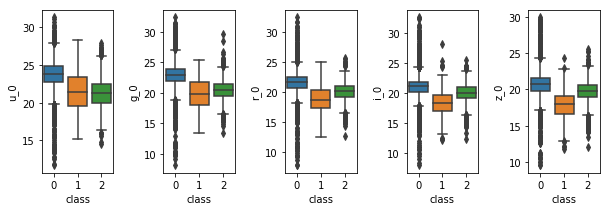

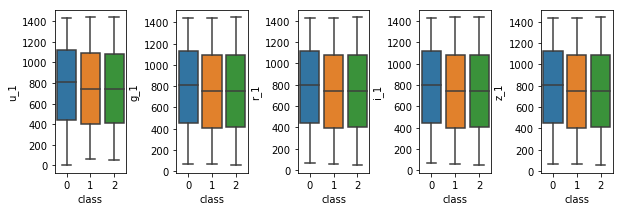

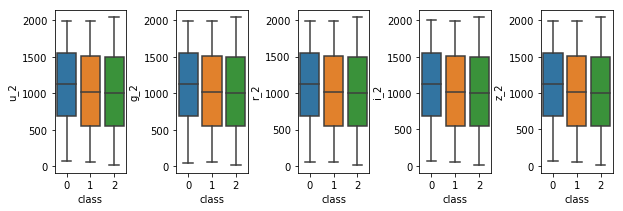

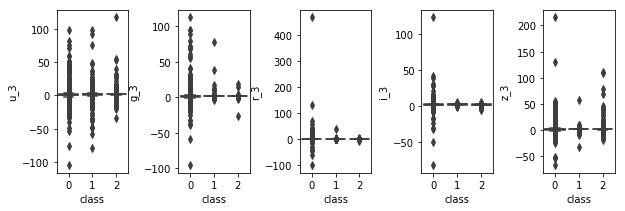

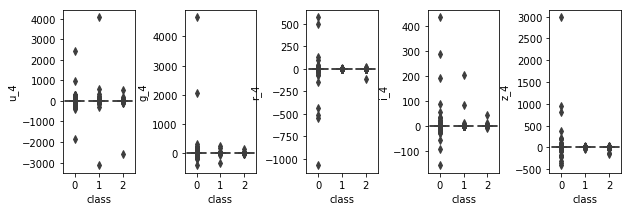

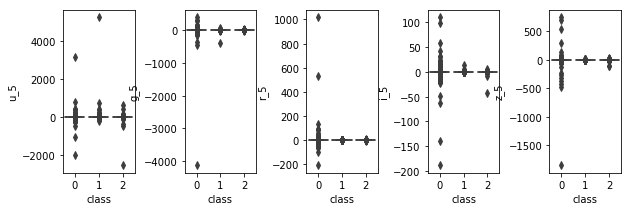

In [11]:
# plot only features which has real-type values
for i in ['0', '1', '2', '3', '4', '5']:
    show_classes_distributions_by_index(i, train_colors)

1-st and 2-nd features are a bit different from others: they don't have outliers, have bigger variance and nearly the same values for different classes    
3-rd, 4-th and 5-th features seem to have very small variance and no effect on class (and have a lot of outliers)   
To be sure let's investigate outliers and check again  

0-th feature has a bit differrent values for differrent classes and might be usefull while prediction, so let's investigate it more.

#### 3-th, 4-th and 5-th outliers

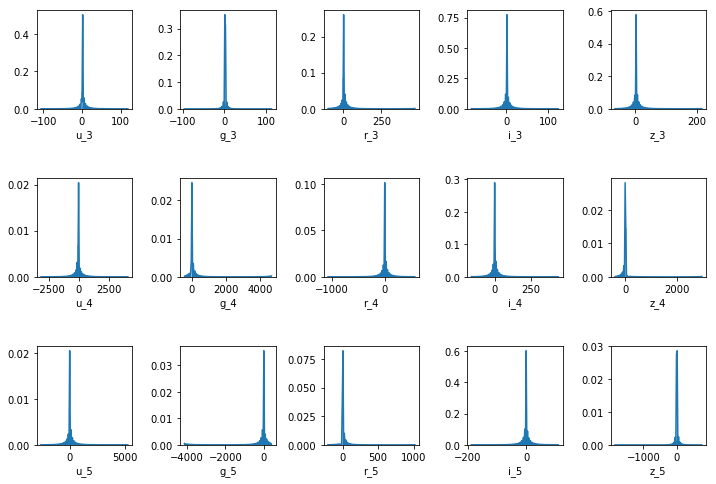

In [12]:
fig, ax = plt.subplots(3,5, figsize=(12,8))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        clean = train[train[f_name].notna()][f_name]
        sns.distplot(clean, ax=ax[i, j])
        j += 1
    i += 1


Using IQR to detect outliers

In [13]:
# detect and save outliers
features = ["{}_{}".format(b, str(i)) for i in range(3, 6) for b in bands_all]

Q1 = train[features].quantile(0.25)
Q3 = train[features].quantile(0.75)

IQR = Q3 - Q1

low_bound = Q1 - 1.5 * IQR
high_bound = Q3 + 1.5 * IQR

clean_data = {}
outliers = {}

for f in features:
    lower_outlier_mask = train[f] < low_bound[f]
    high_outlier_mask = train[f] > high_bound[f]
    
    clean_data[f] = train[~(lower_outlier_mask | high_outlier_mask)]
    outliers[f] = train[lower_outlier_mask | high_outlier_mask]

Try to find the reason for outliers

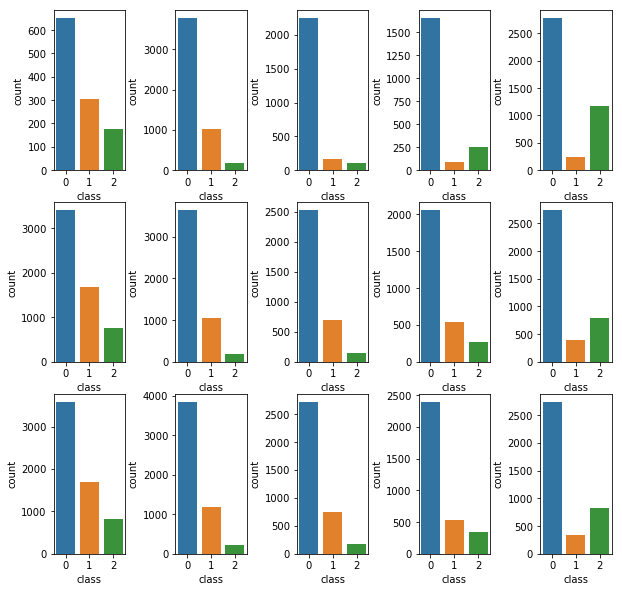

In [14]:
# classes

fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.countplot(x='class', data=outliers[f_name], ax=ax[i, j])
        j += 1
    i += 1

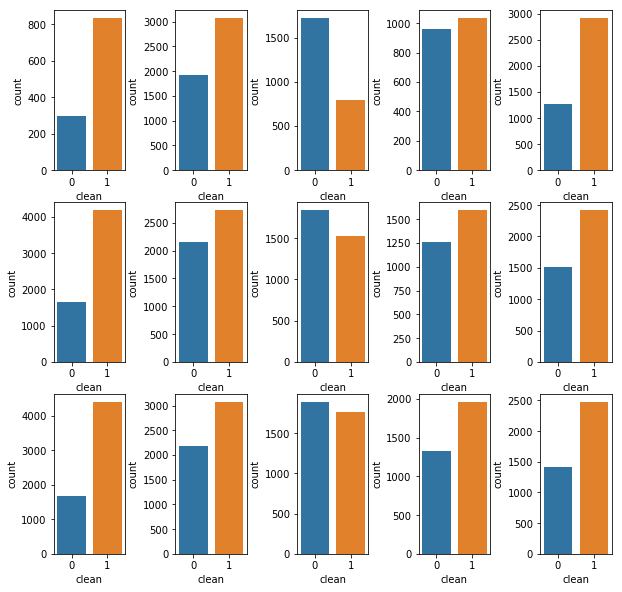

In [15]:
# clean 

fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.countplot(x='clean', data=outliers[f_name], ax=ax[i, j])
        j += 1
    i += 1

~ 10-20% of given features are outliers  
Outliers happen not due to 'noisy' shots (in most cases there are more outliers in clean shots)  
Samples of 0-th class has more outliers than 1-st and 2nd ones


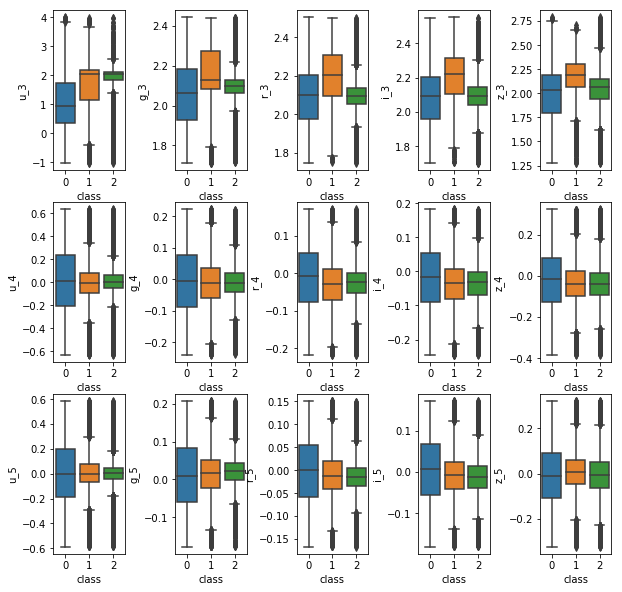

In [16]:
# plot again, without outliers
fig, ax = plt.subplots(3, 5, figsize=(10, 10))
fig.subplots_adjust(wspace=0.7)

i, j = 0, 0
for idx in ['3', '4', '5']:
    j = 0
    for b in bands_all:
        f_name = "{}_{}".format(b, idx)
        sns.boxplot(x='class', y=f_name, data=clean_data[f_name], ax=ax[i, j])
        j += 1
    i += 1
    

Even with outliers removed, 4-th and 5-th features seem to have the same values for each class.  
3-rd features are a bit different for different classes  


#### 0-th color features

0-th color features still have a lot of missing values, but they can probably be usefull while prediction.  
Check, if we can predict them from other features.

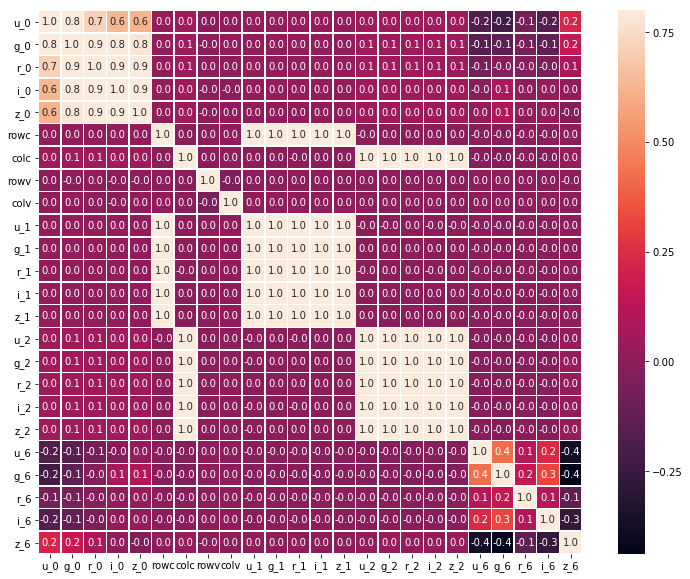

In [17]:
exclude_from_corrmap = ["{}_{}".format(b, n) for n in ['3', '4', '5'] for b in bands_all]
exclude_from_corrmap.extend(['class', 'objid', 'ra', 'dec', 'clean'])

corrmat = train.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat,  annot=True, linewidths=.5, fmt= '.1f', vmax=.8, square=True)

0-th features in training set have strong corrlation with one another. ('u_0' and 'g_0', 'g_0' and 'r_0' and so on), so may be predicted one from another    

1-st and 2-nd features are perfectly correlated inside groups *(-_- hm)*   
Also, 1-st features are perfectly correlated with 'rowc' (O.O) and 2-nd features with 'colc' (why?) !!!!!

Check the same in unlabeled dataset

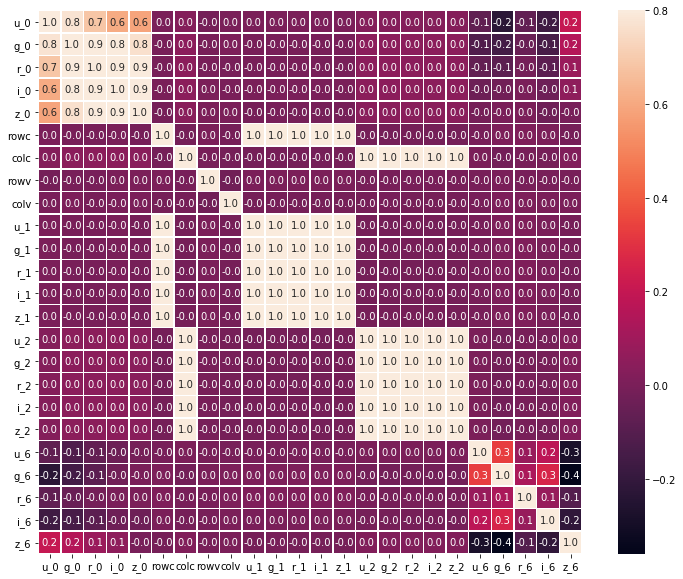

In [18]:
if 'class' in exclude_from_corrmap:
    exclude_from_corrmap.remove('class')

corrmat = unlabeled.drop(exclude_from_corrmap, axis=1).corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(corrmat, annot=True, linewidths=.5, fmt= '.1f', vmax=.8, square=True)

#### Perfect correlation in 1-st and 2-nd features

Let's look closely on these perfectly correlated groups

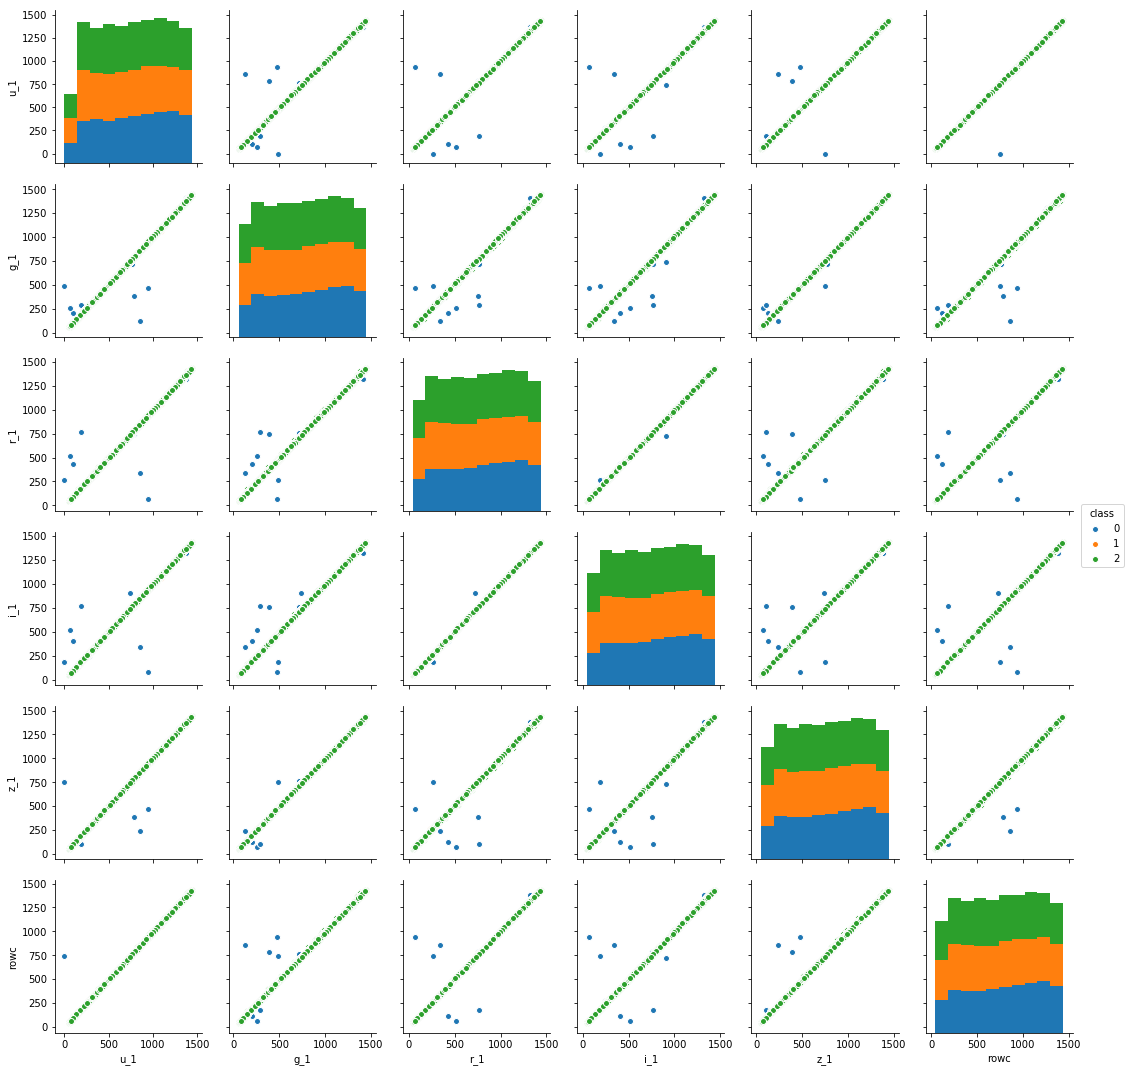

In [19]:
f_features = ["{}_1".format(b) for b in bands_all]
f_features.append('rowc')

group = train[[*f_features, 'class']]
sns.pairplot(group, hue='class', vars=f_features)


Perfect matching)  
Let's check another group

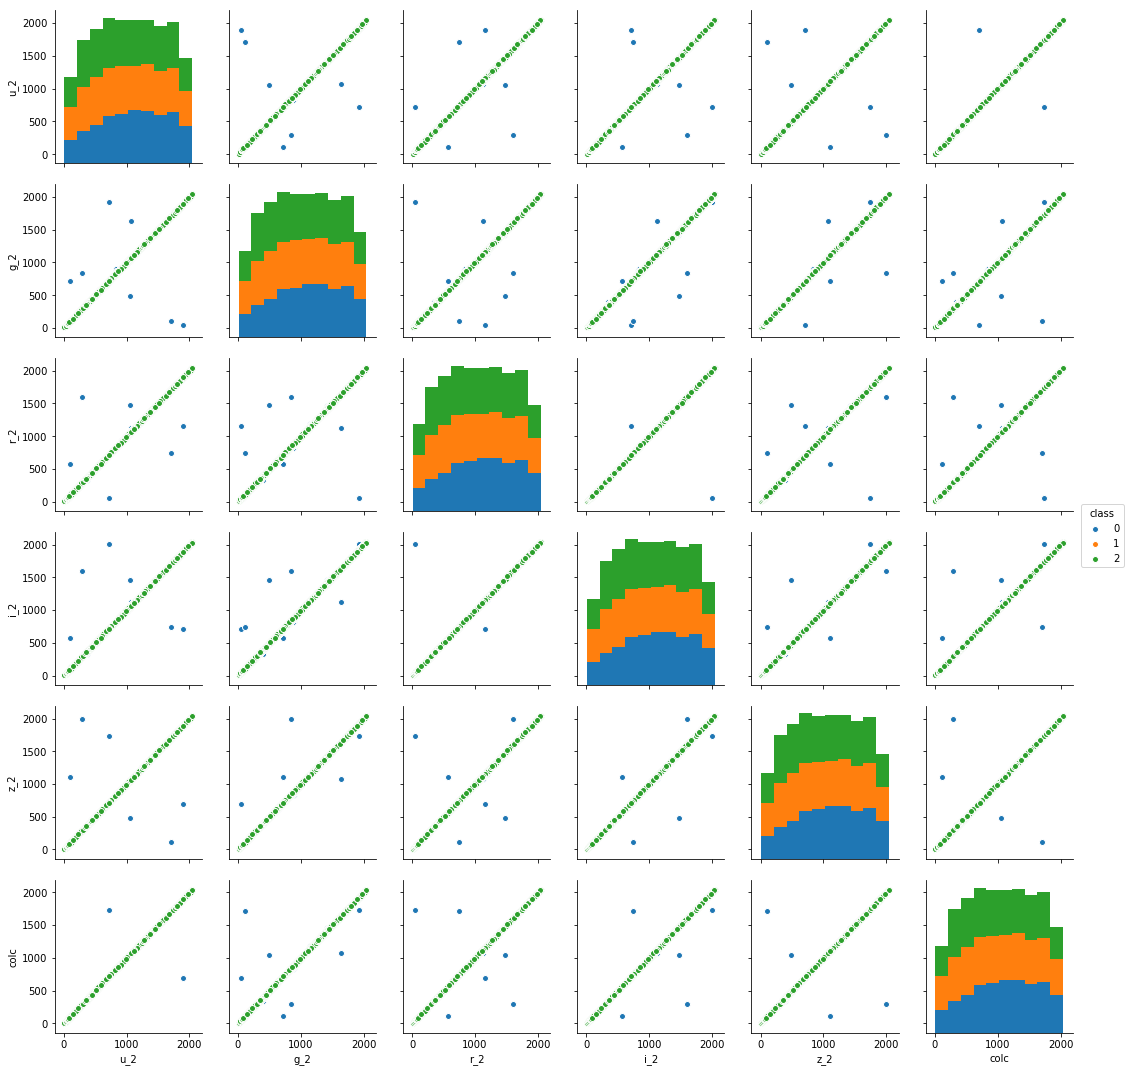

In [20]:
f_features = ["{}_2".format(b) for b in bands_all]
f_features.append('colc')

group = train[[*f_features, 'class']]
sns.pairplot(group, hue='class', vars=f_features)

Since features in each group are almost the same, and different class samples are evenly distributed though values let's keep only one feature from each group.

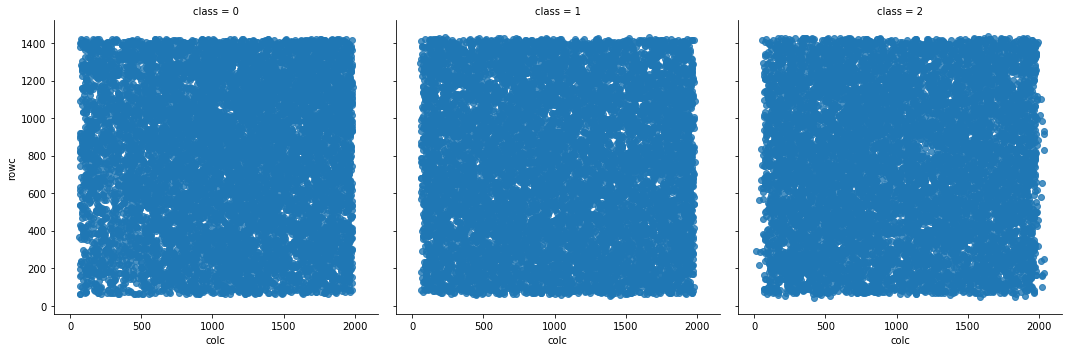

In [21]:
sns.lmplot(x='colc', y='rowc', data=train, col='class', fit_reg=False)

Values of features are evenly distributed in range [0, 2000] and [0, 1400], so it's likely coordinates of object in frame.  
Let's keep 'rowc' and 'colc' columns and drop 1-st and 2-nd features.

#### 6-th color feature

6-th color feature represents categorial data for a photometric measurment.  

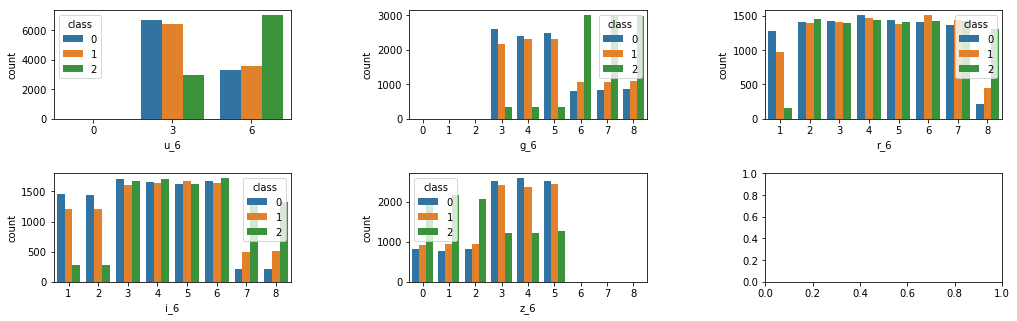

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(17, 5))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    sns.countplot(x=f_name, data=train, ax=ax[i // 3, i % 3], hue='class')

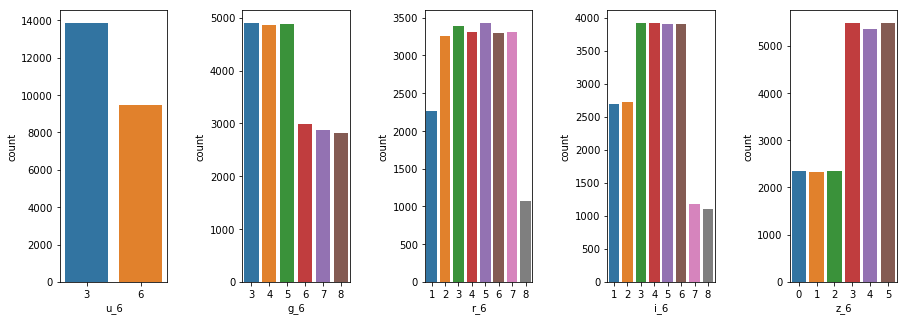

In [23]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
fig.subplots_adjust(wspace=0.7)

for i, b in enumerate(bands_all):
    f_name = "{}_6".format(b)
    sns.countplot(x=f_name, data=unlabeled, ax=ax[i])

#### 'Clean' column and object in frame characteristics 

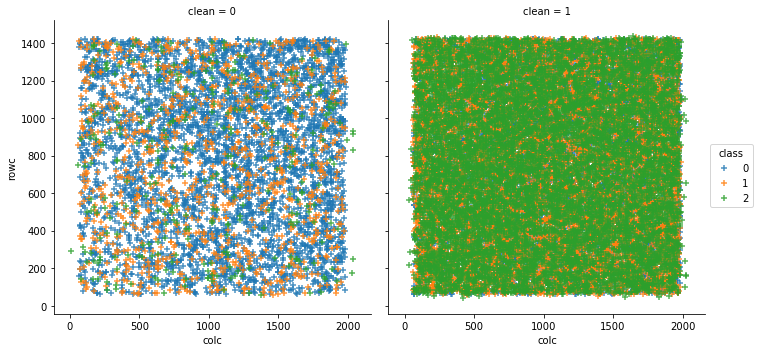

In [24]:
sns.lmplot(x='colc', y='rowc', data=train, col='clean', hue='class', fit_reg=False, markers="+")

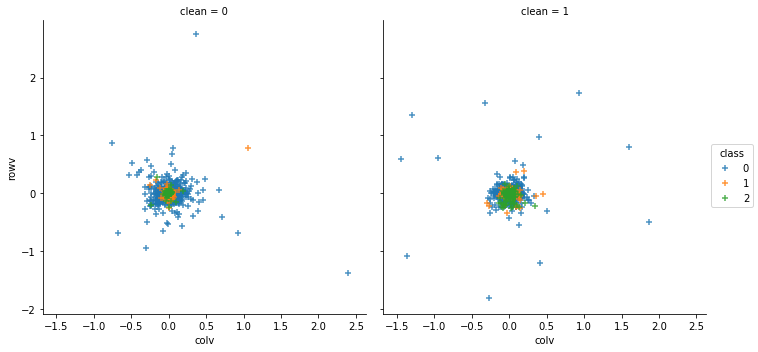

In [25]:
sns.lmplot(x='colv', y='rowv', data=train, col='clean', hue='class', fit_reg=False, markers="+")

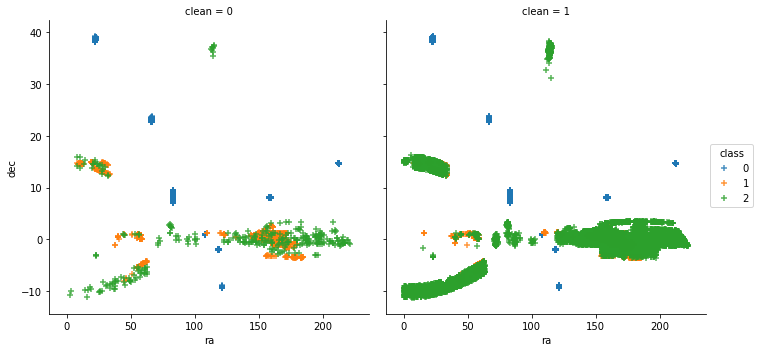

In [46]:
# since ra\dec coordinates in train and test set are completly different I'm not sure if this is worth checking
sns.lmplot(x='ra', y='dec', data=train, col='clean', hue='class', fit_reg=False, markers="+")

clean  class
0      0        3987
       1         959
       2         329
1      2        9671
       1        9041
       0        6013
Name: class, dtype: int64

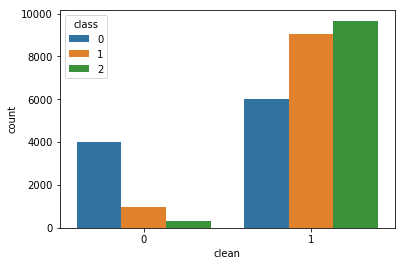

In [27]:
sns.countplot(x='clean', hue='class', data=train)
train.groupby('clean')['class'].value_counts()

'Cleanliness' of the shot doesn't depend on neither object's velocity in frame nor coordinates of object in frame.  
Elements of 1st class has much more clean shots than 'dirty' ones.  

### Conclusion  
  * 3-rd, 4-th and 5-th features are probably not usefull: a lot of missing values, outliers and nearly the same values for different classes
  * Outliers in 3-rd, 4-th and 5-th features are not caused by 'dirty' shots and happen more often in elements of 1 class    
  * 0-th feature may be usefull, but has a lot of missing values. There is a chance to predict NaNs from present 0-th features
  * 1-st and 2-nd features are perfectly correlated (pearsons_r = 1) with 'rowc' and 'colc'
  * Samples of 1-st and 2-nd class are more likely to be captured in clean shot

## Missing values

In [28]:
show_missing_values()

,train,test,unlabeled
u_0,4556,3455,0
g_0,4504,3460,0
r_0,4555,3380,0
i_0,4596,3449,0
z_0,4481,3499,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Unlabeled data has less missing values then training and testing sets.  
Columns '-0', '-3', '-4', '-5' in training set has ~13-15% missing values.  
  
  As I said before, let's try to predict 0-th features from present 0-th features 

#### 0-th feature

Check how many 0-th features are missing at the same time in train dataset

0    13266
1    11664
2     4248
3      764
4       50
5        8
dtype: int64


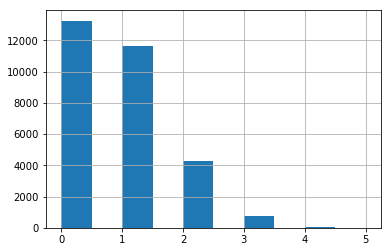

In [29]:
zeros_features = ["{}_0".format(b) for b in bands_all]
num_of_missing_0th = train[zeros_features].isna().sum(axis=1)

print(num_of_missing_0th.value_counts())
num_of_missing_0th.hist()

A few samples have all 0-th features missing, so after 'regression' prediction we still have to fill NaNs with mean values.

In [30]:
train[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.817264,0.717657,0.631143,0.617691
g_0,0.817264,1.000000,0.901610,0.816336,0.782590
r_0,0.717657,0.901610,1.000000,0.931553,0.873073
i_0,0.631143,0.816336,0.931553,1.000000,0.896410
z_0,0.617691,0.782590,0.873073,0.896410,1.000000


In [31]:
unlabeled[zeros_features].corr()

,u_0,g_0,r_0,i_0,z_0
u_0,1.000000,0.775498,0.682887,0.605890,0.590848
g_0,0.775498,1.000000,0.898527,0.816628,0.768118
r_0,0.682887,0.898527,1.000000,0.915039,0.853865
i_0,0.605890,0.816628,0.915039,1.000000,0.866295
z_0,0.590848,0.768118,0.853865,0.866295,1.000000


Prediction of every feature should be based on the most correlated variable:
* u_0 based on g_0  
* g_0 based on r_0  
* r_0 based on i_0  
* i_0 based on r_0  
* z_0 based on i_0  

In [32]:
def fill_nans_based_on_regression(col, based_on_col, data):
    print("\n{} based on {}".format(col, based_on_col))
    
    # get only notna values to train linear regression
    clean_columns_mask = data[[col, based_on_col]].notna().all(axis=1)
    clean_columns = data[clean_columns_mask][[col, based_on_col]]
    
    # get samples where 'col' is NaN and 'based_col' is not NaN
    # (samples, where 'col' value will be predicted)
    col_nan_mask = data[col].isna()
    based_col_notna_mask = data[based_on_col].notna()
    samples_to_predict = data[col_nan_mask & based_col_notna_mask]
    
    # reshape to fit the regression
    X = clean_columns[based_on_col].values.reshape(-1, 1)
    y = clean_columns[col].values.reshape(-1, 1)
    to_predict = samples_to_predict[based_on_col].values.reshape(-1, 1)
    
    reg = LinearRegression()
    reg.fit(X, y)
    print("reg score: {}".format(reg.score(X, y)))
    
    predicted = reg.predict(to_predict).flatten()
    
    num_of_nans_before = data[col].isna().sum()
    
    # fill predicted values instead of NaNs
    idx = samples_to_predict.index
    data.loc[idx, col] = predicted
    
    num_of_nans_after = data[col].isna().sum()
    print("replaced {} NaN values".format(num_of_nans_before - num_of_nans_after))

In [33]:
replacement_scheme = [('r_0', 'i_0'), ('i_0', 'r_0'), ('z_0', 'r_0'), ('g_0', 'r_0'), ('u_0', 'g_0')]

for col, based_on_col in replacement_scheme:
    fill_nans_based_on_regression(col, based_on_col, train)

for col, based_on_col in replacement_scheme:
    fill_nans_based_on_regression(col, based_on_col, test)


r_0 based on i_0
reg score: 0.8677907744593449
replaced 3885 NaN values

i_0 based on r_0
reg score: 0.8856728999444379
replaced 3926 NaN values

z_0 based on r_0
reg score: 0.7625302248742643
replaced 4377 NaN values

g_0 based on r_0
reg score: 0.7919346700916082
replaced 4402 NaN values

u_0 based on g_0
reg score: 0.6422382303904675
replaced 4540 NaN values

r_0 based on i_0
reg score: 0.8407839811848895
replaced 2854 NaN values

i_0 based on r_0
reg score: 0.8608835564380372
replaced 2923 NaN values

z_0 based on r_0
reg score: 0.7446820857487215
replaced 3416 NaN values

g_0 based on r_0
reg score: 0.8010923400872132
replaced 3376 NaN values

u_0 based on g_0
reg score: 0.5750493514492977
replaced 3440 NaN values


In [34]:
show_missing_values()

,train,test,unlabeled
u_0,16,15,0
g_0,102,84,0
r_0,670,526,0
i_0,670,526,0
z_0,104,83,0
rowv,401,681,621
colv,401,681,621
u_3,5173,4836,4935
g_3,1720,1690,1760
r_3,727,752,778


Fill all the rest 0-th features with mean values by columns

In [35]:
train[zeros_features] = train[zeros_features].fillna(train[zeros_features].mean())
test[zeros_features] = test[zeros_features].fillna(test[zeros_features].mean())

train[zeros_features].isna().sum().max(), test[zeros_features].isna().sum().max() 

(0, 0)

#### 1-st, 2-nd color features

In [36]:
# eventually delete 1-st and 2-nd features 
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['1', '2']
columns_to_drop = ["{}_{}".format(b, i) for b in bands for i in indx]

train = train.drop(columns_to_drop, axis=1)
test = test.drop(columns_to_drop, axis=1)

unlabeled = unlabeled.drop(columns_to_drop, axis=1)

#### 3-rd, 4-th and 5-th features

In [37]:
# just fill nans with median value
bands = ['u', 'g', 'r', 'i', 'z']
indx = ['3', '4', '5']
columns_to_fill = ["{}_{}".format(b, i) for b in bands for i in indx]

train[columns_to_fill] = train[columns_to_fill].fillna(train[columns_to_fill].median())
test[columns_to_fill] = test[columns_to_fill].fillna(test[columns_to_fill].median())
unlabeled[columns_to_fill] = unlabeled[columns_to_fill].fillna(unlabeled[columns_to_fill].median())

train[columns_to_fill].isna().sum().max(), test[columns_to_fill].isna().sum().max() 

(0, 0)

#### colv and rowv features

For now we have only 'rowv' and 'colv' missing values  

In [38]:
show_missing_values()

,train,test,unlabeled
rowv,401,681,621
colv,401,681,621


In [39]:
train[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    29599
True       401
dtype: int64

In [40]:
unlabeled[['rowv', 'colv']].isna().all(axis=1).value_counts()

False    22712
True       621
dtype: int64

Columns are both missing or both present in train and unlabeled datasets. Assume, the same situation is in the test set.   
       
As we checked before, columns are probably not relevant to class prediction

In [41]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)
unlabeled.fillna(unlabeled.mean(), inplace=True)

In [42]:
train.isna().sum().max(), test.isna().sum().max()

(0, 0)

In [43]:
train.shape, test.shape

((30000, 34), (23333, 34))

### Conclusion

*  Fill  '-3', '-4', '-5'  columns with median value due to ~13-15% of missing values and ~10-20% outliers
*  Fill '-0' columns with regression results based on present '-0' features
*  Fill all remaining '-0' NaNs with mean values
*  Replace 'rowv' and 'colv' NaNs with mean values

# Prediction

In [44]:
# TODO